In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, KFold
import sklearn.model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc

In [2]:
!ls

README.md			  relax_no_session_time.ipynb
relax_data_science_challenge.pdf  takehome_user_engagement.csv
relax.ipynb			  takehome_users.csv
relax_no_creation_time.ipynb


In [3]:
summary = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])
summary.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
summary.dtypes

time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object

In [5]:
summary.visited.value_counts(dropna=False)

1    207917
Name: visited, dtype: int64

In [6]:
summary['date'] = summary.time_stamp.apply(datetime.toordinal)
summary.head()

,time_stamp,user_id,visited,date
0,2014-04-22 03:53:30,1,1,735345
1,2013-11-15 03:45:04,2,1,735187
2,2013-11-29 03:45:04,2,1,735201
3,2013-12-09 03:45:04,2,1,735211
4,2013-12-25 03:45:04,2,1,735227


In [7]:
# Verify that dates are sorted
summary.groupby('user_id').date.diff().min()

1.0

In [8]:
adopted = (pd.DataFrame(summary.groupby(
            ['user_id','date']).visited.max()).reset_index().groupby(
             'user_id').date.rolling(window=3).apply(lambda x: x[2] - x[0], raw=True).groupby(
             'user_id').min() < 7)
adopted.name = 'adopted'
adopted.head(20)

user_id
1     False
2      True
3     False
4     False
5     False
6     False
7     False
10     True
11    False
13    False
14    False
17    False
19    False
20     True
21    False
22    False
23    False
24    False
25    False
27    False
Name: adopted, dtype: bool

In [9]:
counts = (pd.DataFrame(summary.groupby(
            ['user_id','date']).visited.max()).reset_index().groupby(
             'user_id').date.count())
counts.head(10)

user_id
1       1
2      14
3       1
4       1
5       1
6       1
7       1
10    284
11      1
13      1
Name: date, dtype: int64

In [10]:
pd.DataFrame(counts[counts>1]).join(adopted).head(20)

,date,adopted
user_id,,
2,14,True
10,284,True
19,2,False
20,7,True
25,2,False
33,18,True
42,342,True
43,8,True
50,17,True


In [11]:
# Check this case as a quick test
summary[summary.user_id==60]

,time_stamp,user_id,visited,date
740,2014-03-21 22:56:03,60,1,735313
741,2014-03-29 22:56:03,60,1,735321
742,2014-04-02 22:56:03,60,1,735325
743,2014-04-05 22:56:03,60,1,735328
744,2014-04-22 22:56:03,60,1,735345
745,2014-04-28 22:56:03,60,1,735351
746,2014-05-13 22:56:03,60,1,735366
747,2014-05-15 22:56:03,60,1,735368


In [12]:
users = pd.read_csv('takehome_users.csv', encoding='latin', parse_dates=['creation_time'])
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [13]:
df = users.rename({'object_id':'user_id'},axis=1).set_index('user_id').join(adopted)
df.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
user_id,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False


In [14]:
df.dtypes

creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time           float64
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
adopted                               object
dtype: object

In [15]:
df.isnull().sum()

creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted                       3177
dtype: int64

In [16]:
df.nunique()

creation_time                 11996
name                          11355
email                         11980
creation_source                   5
last_session_creation_time     8821
opted_in_to_mailing_list          2
enabled_for_marketing_drip        2
org_id                          417
invited_by_user_id             2564
adopted                           2
dtype: int64

In [17]:
adopted.isnull().sum()

0

In [18]:
pd.read_csv('takehome_user_engagement.csv').groupby('user_id').count().shape

(8823, 2)

In [19]:
users.shape

(12000, 10)

In [21]:
X = df[~df.adopted.isnull()].drop(['name', 'email','adopted', 'last_session_creation_time', 'creation_time'], axis=1)
y = 1*df[~df.adopted.isnull()].adopted

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
le = LabelEncoder()
X_train.loc[:,'creation_source'] = le.fit_transform(X_train.creation_source)
X_test.loc[:,'creation_source'] = le.transform(X_test.creation_source)

/home/andy/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [24]:
X_train.dtypes, X_test.dtypes, y_train.dtype, y_test.dtype

(creation_source                 int64
 opted_in_to_mailing_list        int64
 enabled_for_marketing_drip      int64
 org_id                          int64
 invited_by_user_id            float64
 dtype: object, creation_source                 int64
 opted_in_to_mailing_list        int64
 enabled_for_marketing_drip      int64
 org_id                          int64
 invited_by_user_id            float64
 dtype: object, dtype('O'), dtype('O'))

In [25]:
d_train = lgb.Dataset(X_train, label=y_train)

In [83]:
params = {}
params['learning_rate'] = 0.2 # shrinkage_rate
params['sub_feature'] = 1      # feature_fraction (small values => use very different submodels)
params['min_data'] = 100         # min_data_in_leaf
params['max_depth'] = 4

nboost=10

In [84]:
cv = lgb.cv(params, d_train, verbose_eval=5, metrics=['auc'], num_boost_round=50, stratified=False)

[5]	cv_agg's auc: 0.57352 + 0.0223707
[10]	cv_agg's auc: 0.577168 + 0.0165711
[15]	cv_agg's auc: 0.573123 + 0.0179904
[20]	cv_agg's auc: 0.569956 + 0.0162437
[25]	cv_agg's auc: 0.568763 + 0.0160261
[30]	cv_agg's auc: 0.568266 + 0.0153137
[35]	cv_agg's auc: 0.565767 + 0.0149042
[40]	cv_agg's auc: 0.564075 + 0.0151394
[45]	cv_agg's auc: 0.563105 + 0.0157549
[50]	cv_agg's auc: 0.561995 + 0.0140437


In [85]:
# 5771

In [86]:
clf = lgb.train(params, d_train, nboost)
pred = clf.predict(X_test).clip(0,1)

In [87]:
y_test.min(), y_test.max(), pred.min(), pred.max()

(0, 1, 0.036384629241808984, 0.2868472196650048)

In [88]:
y_test.nunique()

2

In [89]:
pd.DataFrame(y_test).isnull().sum(), pd.DataFrame(pred).isnull().sum()

(adopted    0
 dtype: int64, 0    0
 dtype: int64)

In [90]:
pred

array([0.18713631, 0.24557049, 0.16522841, ..., 0.12932099, 0.12978098,
       0.16522841])

In [91]:
y_test.shape, pred.shape

((1765,), (1765,))

In [92]:
cutoff = .25

In [93]:
print( confusion_matrix(y_test.values.astype('bool'), pred>cutoff) )

[[1392   35]
 [ 326   12]]


In [94]:
accuracy_score(y_test.values.astype('bool'), pred>cutoff)

0.7954674220963173

Test set ROC AUC: 0.5776134813383479


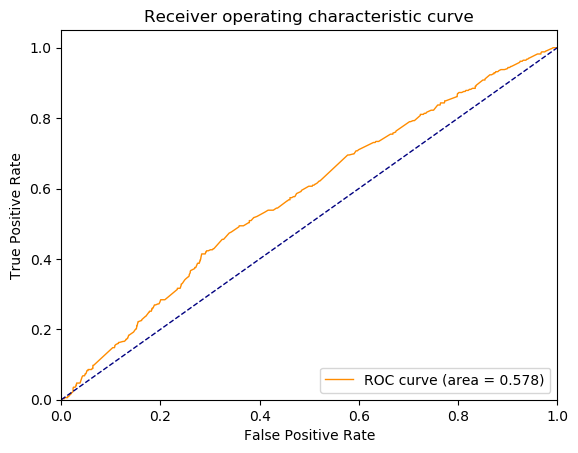

In [95]:
fpr, tpr, _ = roc_curve(y_test.values.astype('bool'), pred)
roc_auc = auc(fpr, tpr)

plt.style.use('default')
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
print('Test set ROC AUC: {}'.format(auc(fpr, tpr)))
plt.show()

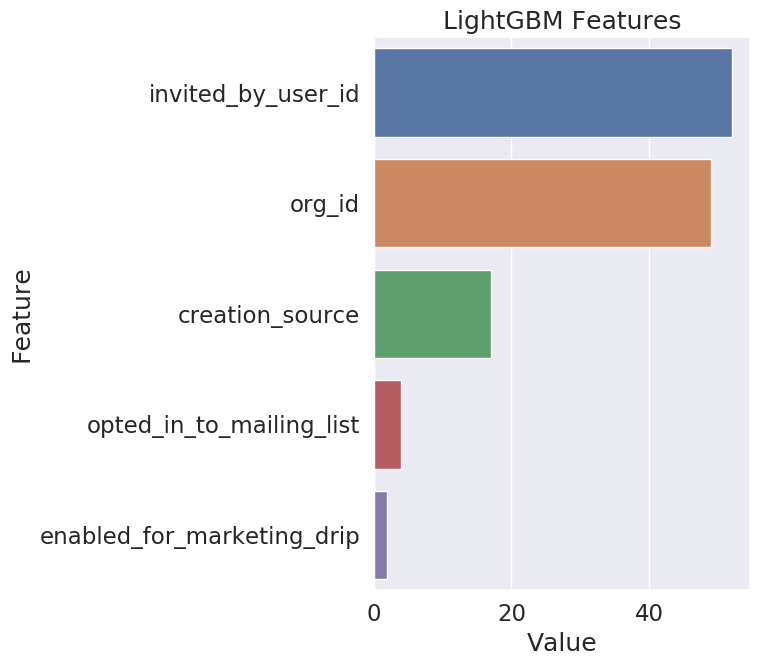

In [96]:
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(8, 7))
sns.set(font_scale = 1.5)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [40]:
summary.time_stamp.min(), summary.time_stamp.max()

(Timestamp('2012-05-31 08:20:06'), Timestamp('2014-06-06 14:58:50'))

In [41]:
df.creation_time.min(), df.creation_time.max()

(Timestamp('2012-05-31 00:43:27'), Timestamp('2014-05-30 23:59:19'))